In [1]:
import torch
import torch.nn as nn
import torch.utils.data as DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.preprocessing import LabelEncoder
import os
import random
from sklearn.model_selection import train_test_split
import librosa
import numpy as np

#### **Load The Dataste**

In [2]:
data_path = './dataset'
directories = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

file_paths = []
labels = []

for directory in directories:
    dir_path = os.path.join(data_path, directory)
    files = os.listdir(dir_path)
    file_paths.extend([os.path.join(dir_path, file) for file in files])
    labels.extend([directory] * len(files))

print(f"Total number of files: {len(file_paths)}")

Total number of files: 302


#### **Format: Ensure the audio files are in a consistent format (e.g., WAV) and sample rate (e.g., 16 kHz)**

In [3]:
from pydub import AudioSegment

def convert_to_wav(file_path, target_sr=32000):
    audio = AudioSegment.from_file(file_path)
    audio = audio.set_frame_rate(target_sr).set_channels(1)  # Set sample rate and make mono
    wav_path = file_path.rsplit('.', 1)[0] + '.wav'
    audio.export(wav_path, format='wav')
    return wav_path

file_paths = [convert_to_wav(file_path) for file_path in file_paths]

d:\Files\Torch\torch\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
def Identify_noise_segments(file_path, threshold=0.5, frame_length=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    energy = np.array([
        np.sum(np.abs(y[i:i + frame_length]**2))
        for i in range(0, len(y), hop_length)
    ])
    noise_segments = np.where(energy < threshold)[0]
    time_stamps = librosa.frames_to_time(noise_segments, sr=sr, hop_length=hop_length)
    return time_stamps

def count_noise_signals(file_paths):
    count = 0
    for i in range (len(file_paths)):
        time_stamps = Identify_noise_segments(file_paths[i])
        if len(time_stamps) > 0:
            count = count + 1
        else:
            continue
    return count

In [5]:
total_noisy_signals = count_noise_signals(file_paths)
print(f"Total number of noisy signals: {total_noisy_signals}")

Total number of noisy signals: 71


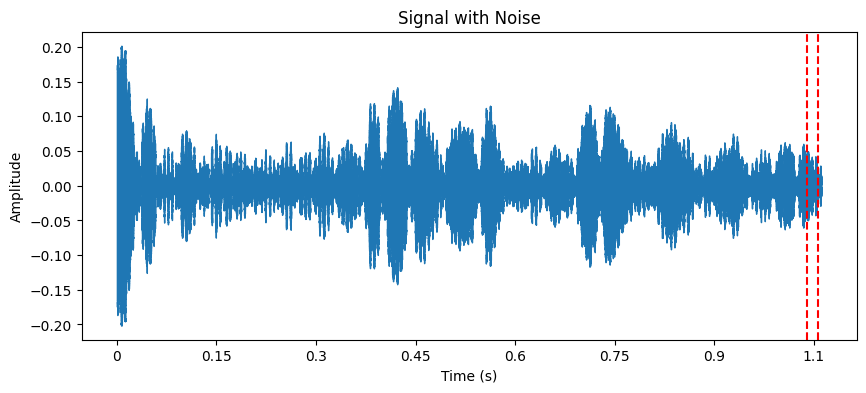

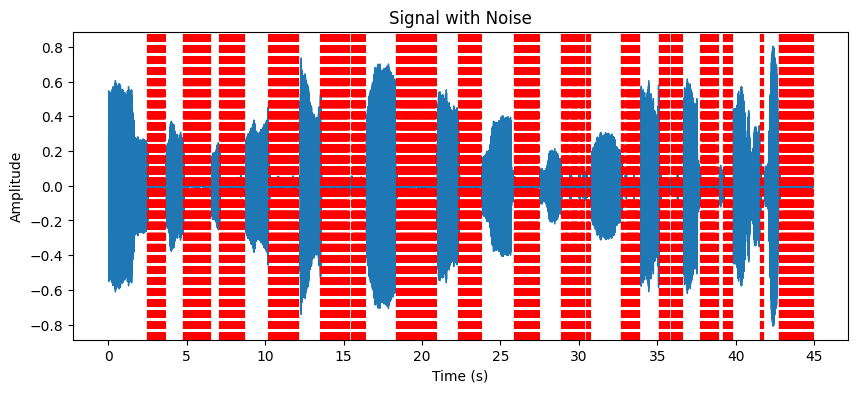

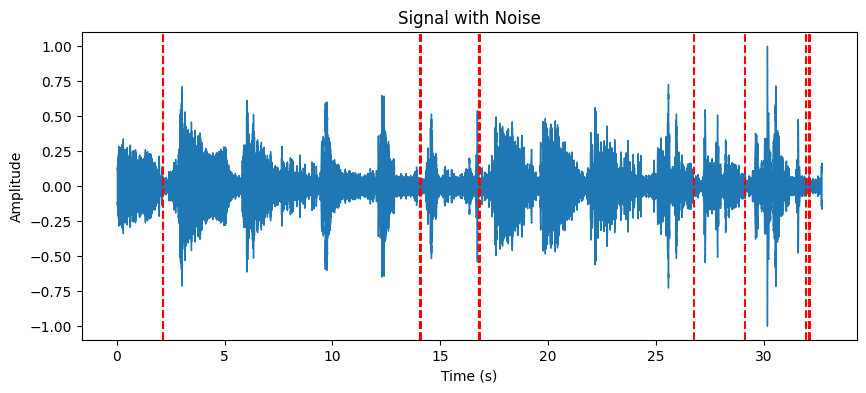

In [6]:
import matplotlib.pyplot as plt

for i in range(15):
    random_index = random.randint(0, len(file_paths) - 1)
    time_stamps = Identify_noise_segments(file_paths[random_index])
    if len(time_stamps) > 0:
        file_path = file_paths[random_index]
        y, sr = librosa.load(file_path, sr=None)

        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(y, sr=sr)
        for stamp in time_stamps:
            plt.axvline(x=stamp, color='red', linestyle='--')
        plt.title('Signal with Noise')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()

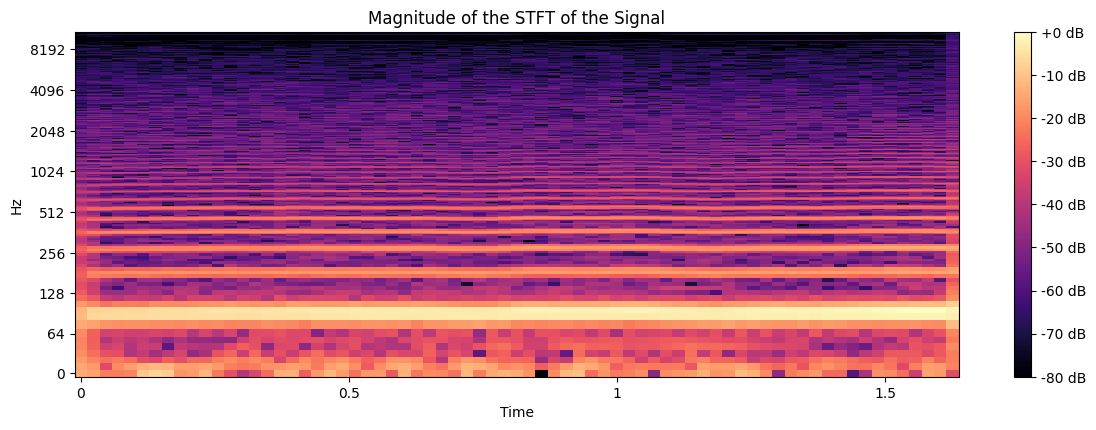

In [7]:
y, sr = librosa.load(file_paths[0], sr=None)

# Compute the STFT of the noisy signal
stft_noisy = librosa.stft(y)
magnitude, phase = librosa.magphase(stft_noisy)

# plot the magnitude of the STFT of the noisy signal and phase

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max), y_axis='log', x_axis='time')
plt.title('Magnitude of the STFT of the Signal')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


d:\Files\Torch\torch\lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
d:\Files\Torch\torch\lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


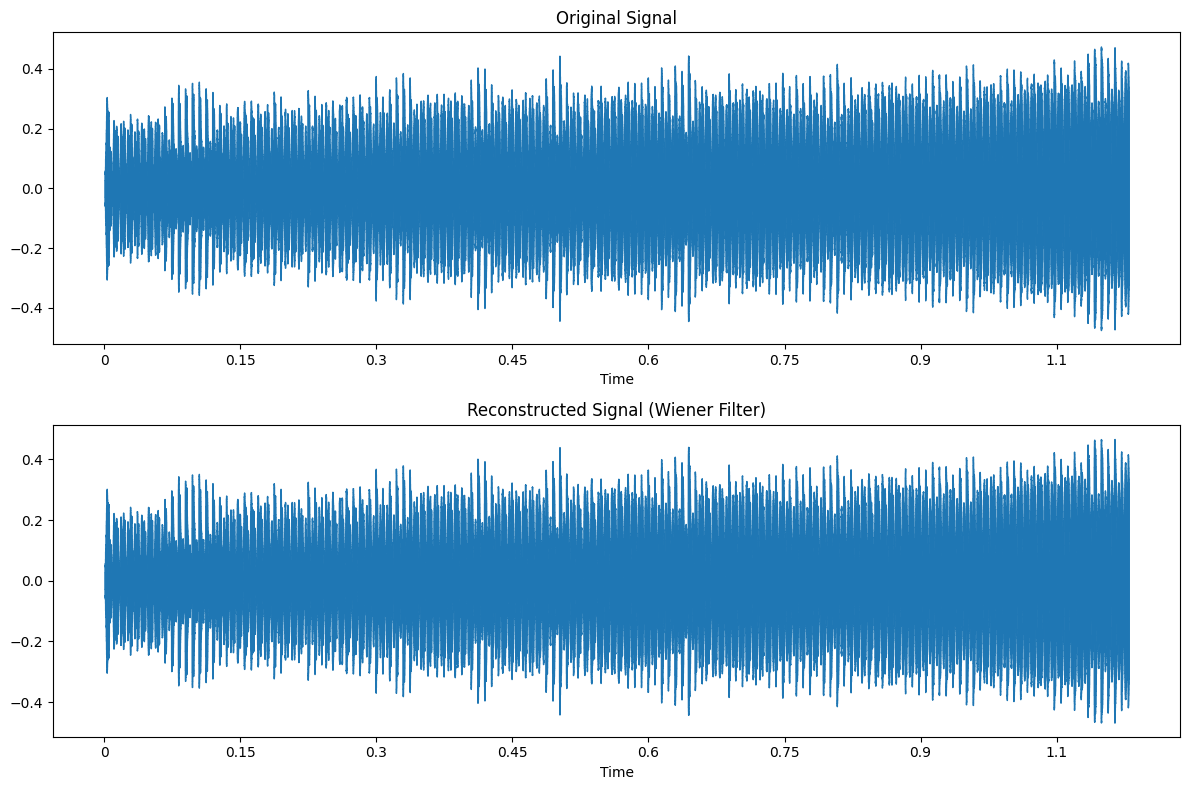

In [8]:
from scipy.signal import wiener

original_signal = librosa.load(file_paths[0], sr=None)[0]
weiner_reconstructed_signal = wiener(original_signal)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
librosa.display.waveshow(original_signal, sr=sr)
plt.title('Original Signal')
plt.tight_layout()

plt.subplot(2, 1, 2)
librosa.display.waveshow(weiner_reconstructed_signal, sr=sr)
plt.title('Reconstructed Signal (Wiener Filter)')
plt.tight_layout()
plt.show()

In [9]:
sample_rates = []

def load_audios(file_path):
    y, sr = librosa.load(file_path, sr=None)
    sample_rates.append(sr)
    return y

signals = [load_audios(file_path) for file_path in file_paths]

print(f"Total number of signals: {len(signals)}")   

Total number of signals: 302


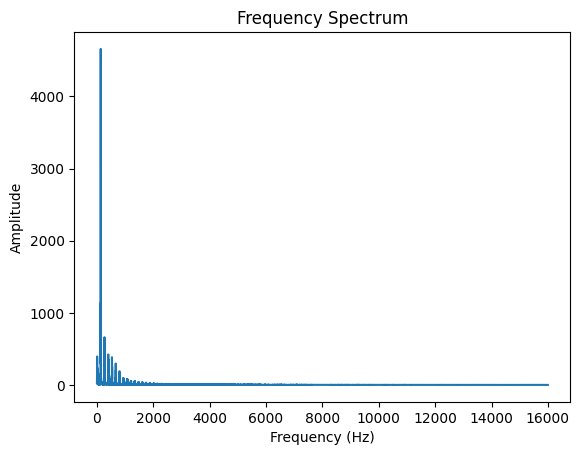

Highest frequency component: 133.65419190661908 Hz
Minimum sampling rate (Nyquist rate): 267.30838381323815 Hz


In [10]:
from scipy.fftpack import fft

audio_signal = signals[0]

sample_rate = 32000

# If stereo, convert to mono by averaging the channels
if audio_signal.ndim > 1:
    audio_signal = audio_signal.mean(axis=1)

# Compute the FFT
N = len(audio_signal)
audio_fft = fft(audio_signal)
audio_fft = np.abs(audio_fft[:N//2])  # Keep only positive frequencies

# Compute the corresponding frequencies
frequencies = np.fft.fftfreq(N, 1/sample_rate)[:N//2]

# Find the highest frequency component
highest_freq = frequencies[np.argmax(audio_fft)]

# Plot the frequency spectrum
plt.plot(frequencies, audio_fft)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

print(f"Highest frequency component: {highest_freq} Hz")


min_sampling_rate = 2 * highest_freq
print(f"Minimum sampling rate (Nyquist rate): {min_sampling_rate} Hz")

In [11]:
def get_minimum_sampling_rate(signal):
    sample_rate = 32000
    if signal.ndim > 1:
        signal = signal.mean(axis=1)
    N = len(signal)
    audio_fft = fft(signal)
    audio_fft = np.abs(audio_fft[:N//2])
    frequencies = np.fft.fftfreq(N, 1/sample_rate)[:N//2]
    highest_freq = frequencies[np.argmax(audio_fft)]
    min_sampling_rate = 2 * highest_freq
   
    return min_sampling_rate

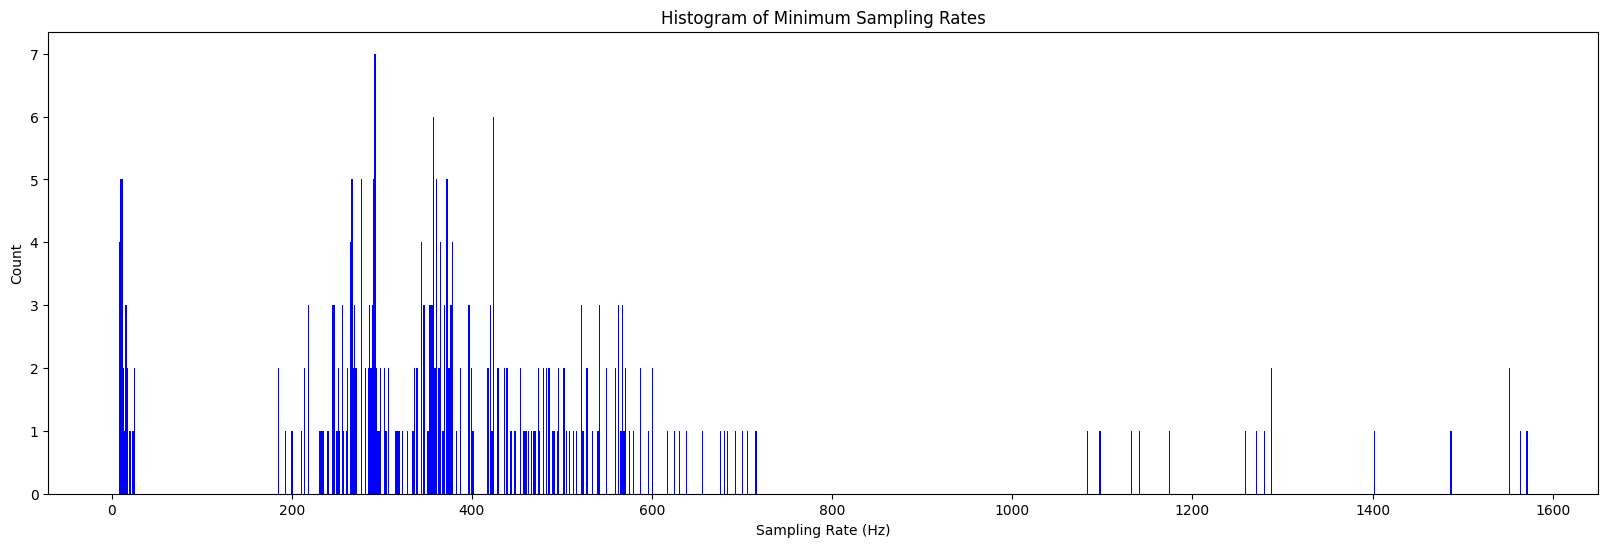

In [12]:
min_sample_rates = [get_minimum_sampling_rate(signal) for signal in signals]

#plot the histogram of the minimum sampling rates
plt.figure(figsize=(20, 6))
plt.hist(min_sample_rates, bins=1036, color='blue')
plt.title('Histogram of Minimum Sampling Rates')
plt.xlabel('Sampling Rate (Hz)')
plt.ylabel('Count')
plt.show()

In [13]:
highest_min_sample_rate = max(min_sample_rates)
print(f"Highest minimum sampling rate: {highest_min_sample_rate} Hz")

Highest minimum sampling rate: 1572.2800196535004 Hz


### **Resample Audio for Consistence**

In [14]:
def convert_to_mono(signal):
    if signal.ndim > 1:
        signal = signal.mean(axis=1)
    return signal

mono_signals = [convert_to_mono(signal) for signal in signals]

In [15]:
def resample_audio(signal, sr, target_sr):
    resampled_signal = librosa.resample(y=signal, orig_sr=sr, target_sr=target_sr)
    return resampled_signal

resampled_signals = [resample_audio(signal, sr=32000, target_sr=8000) for signal in mono_signals]

#### **Noise Reduction Techniques**
- Spectral Subtraction: Estimate the noise spectrum and subtract it from the noisy signal.
- Wiener Filtering: Use this technique to reduce noise by estimating the clean signal based on the noisy input.

In this case Wiener Filtering is usefull. this isn't a real time project so Spectrul Substractions not usefull.

In [16]:
def apply_wiener_filter(signal):
    y_reconstructed = wiener(signal)
    return y_reconstructed

denoised_signals = [apply_wiener_filter(signal) for signal in resampled_signals]
print(f"Total number of denoised signals: {len(denoised_signals)}")

Total number of denoised signals: 302


#### **Overlap-Add (OLA)**

Overlap Processing: Use the overlap-add method to ensure that adjacent frames have a 30-50% overlap. This prevents loss of important information and allows for accurate reconstruction of the original signal from the processed frames

In [17]:
fs = 8000

# Function to frame a single signal
def frame_signal(signal, frame_size, hop_size):
    num_frames = int((len(signal) - frame_size) / hop_size) + 1
    frames = np.zeros((num_frames, frame_size))
    
    for i in range(num_frames):
        start = i * hop_size
        frames[i] = signal[start:start + frame_size]
    
    return frames

# Function to apply windowing to frames
def apply_window(frames, window_type='hamming'):
    if window_type == 'hamming':
        window = np.hamming(frames.shape[1])
    elif window_type == 'hanning':
        window = np.hanning(frames.shape[1])
    else:
        raise ValueError(f"Unsupported window type: {window_type}")
    
    return frames * window

# Function to overlap-add frames into a single signal
def overlap_add(frames, frame_size, hop_size):
    num_frames = frames.shape[0]
    output_length = (num_frames - 1) * hop_size + frame_size
    output_signal = np.zeros(output_length)
    
    for i in range(num_frames):
        start = i * hop_size
        output_signal[start:start + frame_size] += frames[i]
    
    return output_signal

# Function to process a list of signals
def process_signals(signals, frame_size, hop_size, window_type='hamming'):
    processed_signals = []
    
    for signal in signals:
        frames = frame_signal(signal, frame_size, hop_size)
        windowed_frames = apply_window(frames, window_type)
        reconstructed_signal = overlap_add(windowed_frames, frame_size, hop_size)
        processed_signals.append(reconstructed_signal)
    
    return processed_signals


frame_size = int(0.025 * fs)  
hop_size = int(0.010 * fs)   

processed_signals = process_signals(signals, frame_size, hop_size, window_type='hamming')

print(len(processed_signals))


302


In [18]:
def compute_log_mel_spectrogram(signal, sr, n_fft, hop_length, n_mels):
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

n_fft = 2048  # FFT window size
hop_length = 512  # Number of samples between successive frames
n_mels = 128  # Number of Mel bands

spectograms = [compute_log_mel_spectrogram(signal, sr, n_fft, hop_length, n_mels) for signal in processed_signals]
print(len(spectograms))

302


#### **Feature Extraction**
- Spectrogram Generation: Convert the audio frames into spectrograms, which visually represent the frequency content of the audio over time. Mel spectrograms are particularly useful as they align more closely with human auditory perception.

- Log-Mel Spectrogram: Further process the Mel spectrogram by applying a logarithmic transformation to enhance visualization and feature extraction, making it suitable for deep learning models.

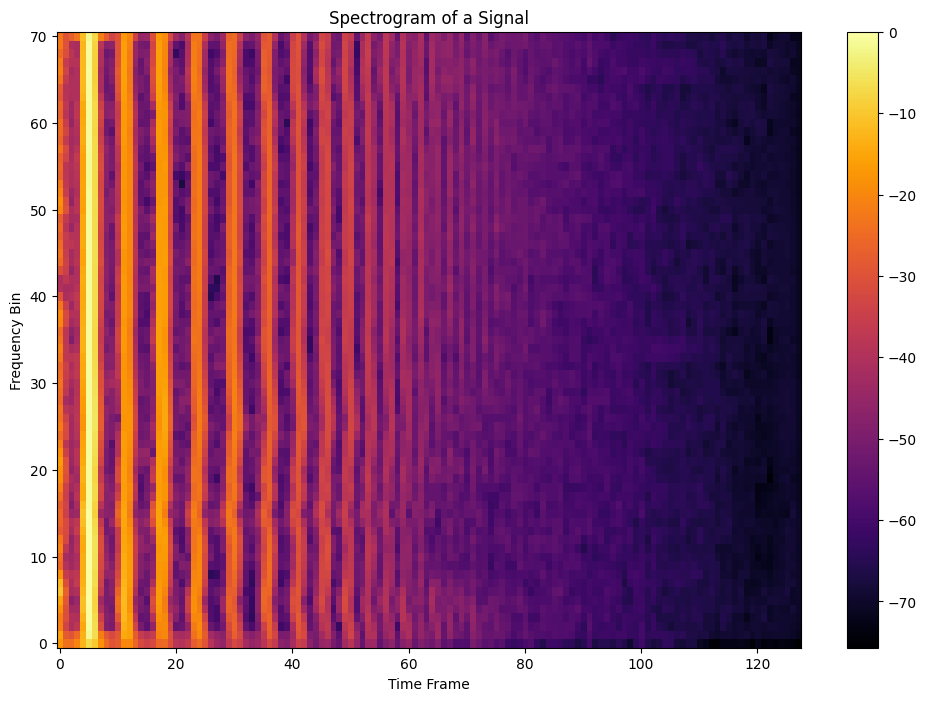

In [19]:
#plot a sample spectrogram

plt.figure(figsize=(12, 8))
plt.imshow(spectograms[10].T, aspect='auto', origin='lower', cmap='inferno')
plt.title('Spectrogram of a Signal')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.colorbar()
plt.show()

#### **Normalization**
- Amplitude Scaling: Normalize the amplitude of the audio signals to ensure consistent signal magnitudes across the dataset, preventing bias towards louder signals

In [20]:
normalized_signals = [signal / np.max(np.abs(signal), axis=0) for signal in spectograms]

#### **Make all euqal Shape**

In [21]:
# Define the padding function

def pad_sequence(sequence, max_length, padding_value=0):
    padded_sequence = np.full((sequence.shape[0], max_length), padding_value)
    padded_sequence[:, :sequence.shape[1]] = sequence
    return padded_sequence

max_length = max(signal.shape[1] for signal in normalized_signals)
padded_signals = [pad_sequence(signal, max_length) for signal in normalized_signals]

In [22]:
## convert to float32

padded_signals = [signal.astype(np.float32) for signal in padded_signals]

In [23]:
padded_signal_numpy = np.array(padded_signals)
padded_signal_numpy[0].shape

(128, 4857)

#### **Data Splits**

In [24]:
combined = list(zip(padded_signals, labels))
random.shuffle(combined)
file_paths[:], labels[:] = zip(*combined)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

train_signals, test_signals, train_labels, test_labels = train_test_split(padded_signals, encoded_labels, test_size=0.2, random_state=42)
train_signals, valid_signals, train_labels, valid_labels = train_test_split(train_signals, train_labels, test_size=0.2, random_state=42)

print(f"Train set length: {len(train_signals)}")
print(f"Validation set length: {len(valid_signals)}")
print(f"Test set length: {len(test_signals)}")

Train set length: 192
Validation set length: 49
Test set length: 61


In [25]:
# check data count for each class label

unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(valid_labels, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 49, 1: 96, 2: 47}
{0: 13, 1: 23, 2: 13}
{0: 22, 1: 23, 2: 16}


In [26]:
reshaped_train_signals = [signal.reshape(1, *signal.shape) for signal in train_signals]
reshaped_valid_signals = [signal.reshape(1, *signal.shape) for signal in valid_signals]
reshaped_test_signals = [signal.reshape(1, *signal.shape) for signal in test_signals]

reshaped_train_signals[5].shape

(1, 128, 4857)

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = None
        self.fc2 = None
        self.num_classes = num_classes
        self._initialize_fc_layers()
        
    def _initialize_fc_layers(self):
        # Create a dummy input to infer the size of the flattened tensor
        dummy_input = torch.zeros(1, 1, 128, 4857)
        dummy_output = self.pool(F.relu(self.conv1(dummy_input)))
        dummy_output = self.pool(F.relu(self.conv2(dummy_output)))
        flattened_size = dummy_output.numel()
        
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, self.num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
num_classes = len(np.unique(labels))
model = AudioCNN(num_classes)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the data loaders
batch_size = 32

train_dataset = DataLoader.TensorDataset(torch.tensor(reshaped_train_signals), torch.tensor(train_labels))
train_loader = DataLoader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = DataLoader.TensorDataset(torch.tensor(reshaped_valid_signals), torch.tensor(valid_labels))
valid_loader = DataLoader.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataset = DataLoader.TensorDataset(torch.tensor(reshaped_test_signals), torch.tensor(test_labels))
test_loader = DataLoader.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to calculate the accuracy of the model
def calculate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for signals, labels in loader:
            outputs = model(signals)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

C:\Users\anuda\AppData\Local\Temp\ipykernel_12120\3229765787.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  train_dataset = DataLoader.TensorDataset(torch.tensor(reshaped_train_signals), torch.tensor(train_labels))


Epoch 1/10, Training Loss: 26.105895499388378, Validation Loss: 3.8539011478424072
Epoch 2/10, Training Loss: 1.6867560148239136, Validation Loss: 1.1218942999839783
Epoch 3/10, Training Loss: 1.031127393245697, Validation Loss: 1.0912711024284363
Epoch 4/10, Training Loss: 0.999247819185257, Validation Loss: 1.078554928302765
Epoch 5/10, Training Loss: 0.9738813837369283, Validation Loss: 1.0943076014518738
Epoch 6/10, Training Loss: 0.9499351382255554, Validation Loss: 1.1126613020896912
Epoch 7/10, Training Loss: 0.9328260819117228, Validation Loss: 1.157263308763504
Epoch 8/10, Training Loss: 0.9124275346597036, Validation Loss: 1.223722755908966
Epoch 9/10, Training Loss: 0.8840127289295197, Validation Loss: 1.3001434803009033
Epoch 10/10, Training Loss: 0.8522534171740214, Validation Loss: 1.2000410854816437


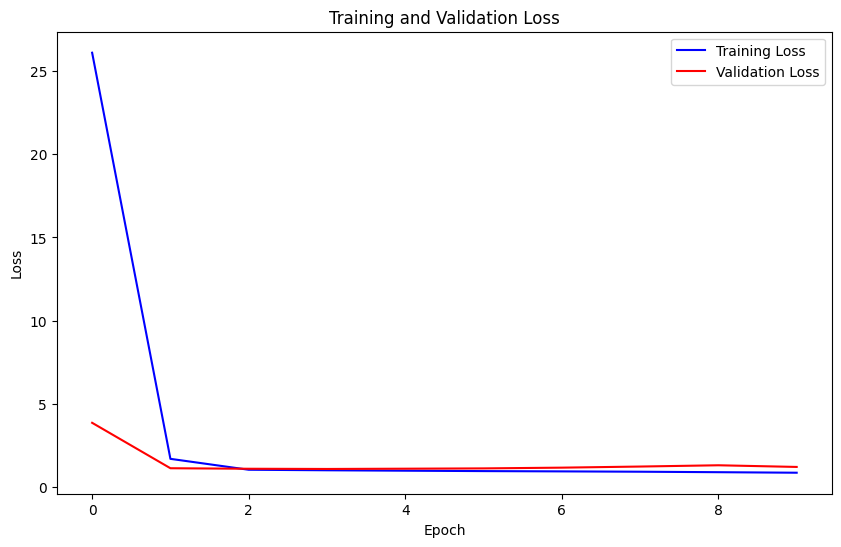

In [28]:

# Train the model

num_epochs = 10

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (signals, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    valid_loss = 0.0

    for i, (signals, labels) in enumerate(valid_loader):
        outputs = model(signals)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()

    valid_loss /= len(valid_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {valid_loss}")

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(valid_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
device = 'cpu'

def make_predictions_and_calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for signals, labels in data_loader:
            signals, labels = signals.to(device), labels.to(device)  # Move data to the GPU
            outputs = model(signals)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    return accuracy, np.array(all_predictions), np.array(all_labels)

# Calculate accuracy on the training, validation, and test datasets
train_accuracy, train_predictions, train_labels = make_predictions_and_calculate_accuracy(model, train_loader, device)
valid_accuracy, valid_predictions, valid_labels = make_predictions_and_calculate_accuracy(model, valid_loader, device)
test_accuracy, test_predictions, test_labels = make_predictions_and_calculate_accuracy(model, test_loader, device)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {valid_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")